In [3]:
import pandas as pd
import ydata_profiling as ydp
import seaborn as sns
# 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
%matplotlib inline
from aux_functions.aux_plots import (plot_boxplot_histogram, plot_scatterplot, plot_distribution_actual_predicted)
from aux_functions.statistics import (test_pearson_correlation, apply_linear_regression, evaluate_linear_regression)

# Importing the dataset

In [4]:
columns = ['lenght_of_stay', 'age', 'infection_risk', 'routine_culturing_ratio', 'routine_xray_ratio', 'num_beds', 'med_school_affil', 'region', 'avg_census', 'num_nurses', 'avelbl_services']
df = pd.read_csv("data/dataset.txt", sep=" ", header=None, names=columns)
df.head()   

,lenght_of_stay,age,infection_risk,routine_culturing_ratio,routine_xray_ratio,num_beds,med_school_affil,region,avg_census,num_nurses,avelbl_services
1,7.13,55.7,4.1,9.0,39.6,279,2,4,207,241,60.0
2,8.82,58.2,1.6,3.8,51.7,80,2,2,51,52,40.0
3,8.34,56.9,2.7,8.1,74.0,107,2,3,82,54,20.0
4,8.95,53.7,5.6,18.9,122.8,147,2,4,53,148,40.0
5,11.20,56.5,5.7,34.5,88.9,180,2,1,134,151,40.0


In [6]:
df['ln_num_beds'] =  np.log(df['num_beds'])
df['ln_avg_census'] =  np.log(df['avg_census'])
df['ln_num_nurses'] =  np.log(df['num_nurses'])
df.drop(columns=['num_beds', 'avg_census', 'num_nurses'])

,lenght_of_stay,age,infection_risk,routine_culturing_ratio,routine_xray_ratio,med_school_affil,region,avelbl_services,ln_num_beds,ln_avg_census,ln_num_nurses
1,7.13,55.7,4.1,9.0,39.6,2,4,60.0,5.631212,5.332719,5.484797
2,8.82,58.2,1.6,3.8,51.7,2,2,40.0,4.382027,3.931826,3.951244
3,8.34,56.9,2.7,8.1,74.0,2,3,20.0,4.672829,4.406719,3.988984
4,8.95,53.7,5.6,18.9,122.8,2,4,40.0,4.990433,3.970292,4.997212
5,11.20,56.5,5.7,34.5,88.9,2,1,40.0,5.192957,4.897840,5.017280
...,...,...,...,...,...,...,...,...,...,...,...
109,11.80,53.8,5.7,9.1,116.9,1,2,62.9,6.347389,6.089045,6.150603
110,9.50,49.3,5.8,42.0,70.9,2,3,22.9,4.584967,4.219508,3.828641
111,7.70,56.9,4.4,12.2,67.9,2,4,62.9,4.859812,4.442651,4.912655
112,17.94,56.2,5.9,26.4,91.8,1,1,62.9,6.727432,6.673298,6.008813


In [7]:
# profile = ydp.ProfileReport(df, title="Profiling Report")
# profile.to_file("data_profile_v2.html")


In [8]:
df.head()

,lenght_of_stay,age,infection_risk,routine_culturing_ratio,routine_xray_ratio,num_beds,med_school_affil,region,avg_census,num_nurses,avelbl_services,ln_num_beds,ln_avg_census,ln_num_nurses
1,7.13,55.7,4.1,9.0,39.6,279,2,4,207,241,60.0,5.631212,5.332719,5.484797
2,8.82,58.2,1.6,3.8,51.7,80,2,2,51,52,40.0,4.382027,3.931826,3.951244
3,8.34,56.9,2.7,8.1,74.0,107,2,3,82,54,20.0,4.672829,4.406719,3.988984
4,8.95,53.7,5.6,18.9,122.8,147,2,4,53,148,40.0,4.990433,3.970292,4.997212
5,11.20,56.5,5.7,34.5,88.9,180,2,1,134,151,40.0,5.192957,4.897840,5.017280


# EDA

## Univariate analysis

### Measures of central tendency and dispersion

In [9]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)
df.describe()

,lenght_of_stay,age,infection_risk,routine_culturing_ratio,routine_xray_ratio,num_beds,med_school_affil,region,avg_census,num_nurses,avelbl_services,ln_num_beds,ln_avg_census,ln_num_nurses
count,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0
mean,9.6,53.2,4.4,15.8,81.6,252.2,1.8,2.4,191.4,173.2,43.2,5.3,4.9,4.8
std,1.9,4.5,1.3,10.2,19.4,192.8,0.4,1.0,153.8,139.3,15.2,0.7,0.8,0.8
min,6.7,38.8,1.3,1.6,39.6,29.0,1.0,1.0,20.0,14.0,5.7,3.4,3.0,2.6
25%,8.3,50.9,3.7,8.4,69.5,106.0,2.0,2.0,68.0,66.0,31.4,4.7,4.2,4.2
50%,9.4,53.2,4.4,14.1,82.3,186.0,2.0,2.0,143.0,132.0,42.9,5.2,5.0,4.9
75%,10.5,56.2,5.2,20.3,94.1,312.0,2.0,3.0,252.0,218.0,54.3,5.7,5.5,5.4
max,19.6,65.9,7.8,60.5,133.5,835.0,2.0,4.0,791.0,656.0,80.0,6.7,6.7,6.5


### Boxplots and histograms
* See "./imgs/box_hist" for results

In [10]:
cols = df.columns
for col in cols:
    if col != 'region' and col != 'med_school_affil':
        fig = plot_boxplot_histogram(df[col], col)
        fig.savefig(f'./imgs/box_hist/{col}.png')  # Save the figure

### Testing for normality on infection_risk

In [11]:
norm_test = sc.shapiro(np.array(df['infection_risk']))
print("Statistic of Shapiro Wilk test: ", norm_test.statistic)
print("p-value of Shapiro Wilk test: ", norm_test.pvalue)

Statistic of Shapiro Wilk test:  0.9820429682731628
p-value of Shapiro Wilk test:  0.1338874250650406


- Interpretation of S-W test: Since we had a small sample size, determining the distribution of the variable X was important for choosing an appropriate statistical method. So a Shapiro-Wilk test was performed and did not show evidence of non-normality (W = 0.98, p-value = 0.13).

## Bivariate analysis

### Calculating the correlation matrix

<Axes: >

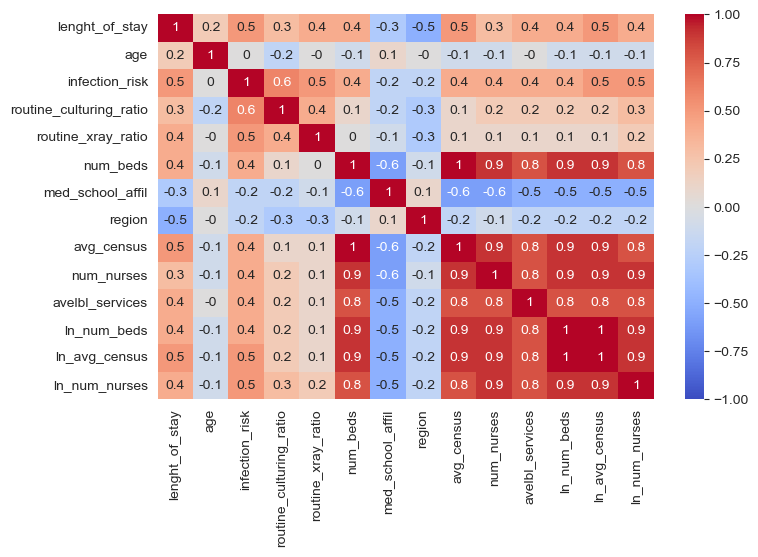

In [12]:
corr_matrix = round(df.corr(),1)
# corr_matrix
fig, ax = plt.subplots(figsize=(8,5))  
sns.heatmap(corr_matrix, annot = True, vmin=-1,vmax=1, cmap=sns.color_palette("coolwarm", as_cmap=True), ax=ax)
# sns.heatmap(corr_matrix, annot=True)

### Applying a pearson's correlation test

In [13]:
target_variable = 'infection_risk'
for col in ['lenght_of_stay', 'routine_culturing_ratio', 'ln_num_nurses']:
    pearson_res = test_pearson_correlation(df, col, target_variable)
    print(">> Pearson's correlation result for", col)
    print('Pearsons r:', round(pearson_res.statistic,2), ';', 'pValue:', round(pearson_res.pvalue,3))
    print(pearson_res.confidence_interval()) # Im not sure if this is a 0.95 confidence interval! Weirdly didn't find the info in the docs

>> Pearson's correlation result for lenght_of_stay
Pearsons r: 0.53 ; pValue: 0.0
ConfidenceInterval(low=0.3868337609236219, high=0.6537510724268812)
>> Pearson's correlation result for routine_culturing_ratio
Pearsons r: 0.56 ; pValue: 0.0
ConfidenceInterval(low=0.4175602271913731, high=0.6742438110841824)
>> Pearson's correlation result for ln_num_nurses
Pearsons r: 0.55 ; pValue: 0.0
ConfidenceInterval(low=0.4016417866999432, high=0.6636762697459764)


* Analysis: There is a statisticaly significant moderate linear correlation between lenght of stay and infection risk; and the same occurs for routine_culturing_ratio and infection risk

### Evaluating linear relationship between variables of interest

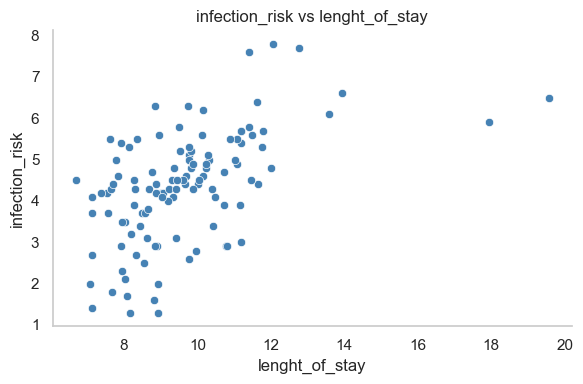

In [14]:
plot_scatterplot(df, 'lenght_of_stay', 'infection_risk')

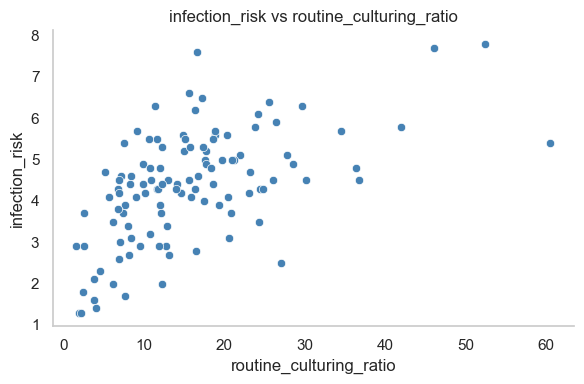

In [15]:
plot_scatterplot(df, 'routine_culturing_ratio', 'infection_risk')

log correlation 0.633145638294715


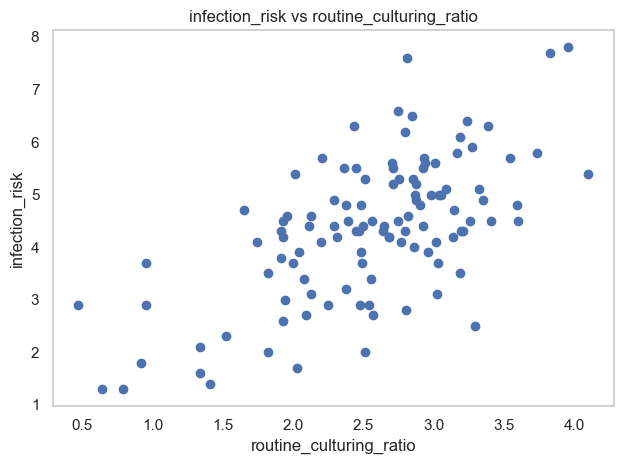

In [16]:
from scipy import stats
print("log correlation", stats.pearsonr(np.array(np.log(df.routine_culturing_ratio)), np.array(df.infection_risk)).statistic)

x= np.log(df.routine_culturing_ratio)
y = df.infection_risk

plt.scatter(x, y)
x_axis, y_axis = 'routine_culturing_ratio', 'infection_risk'
plt.title(f'{y_axis} vs {x_axis}')
plt.xlabel(x_axis)
plt.ylabel(y_axis)
plt.tight_layout()
plt.show()

* Analysis: it appears that the relationship between these variables is linear (is it though???? So subjective this)

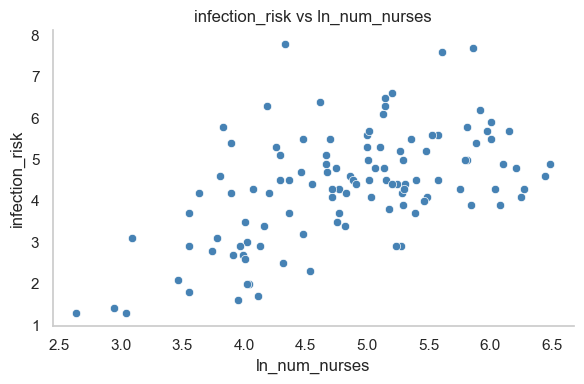

In [17]:
plot_scatterplot(df, 'ln_num_nurses', 'infection_risk')

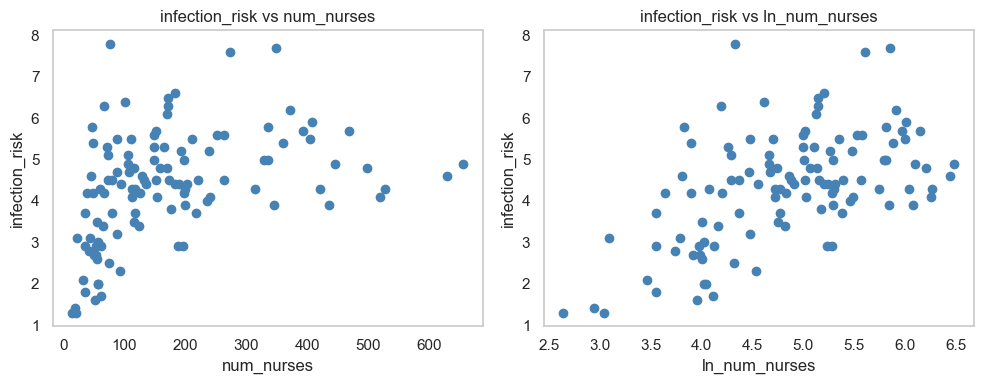

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
x1 = df['num_nurses']
x2 = df['ln_num_nurses']
y = df['infection_risk']
axs[0].scatter(x1, y, label='Scatter 1', color='steelblue', marker='o')
axs[0].set_title('infection_risk vs num_nurses')
axs[0].set_xlabel('num_nurses')
axs[0].set_ylabel('infection_risk')
axs[1].scatter(x2, y, label='Scatter 2', color='steelblue', marker='o')
axs[1].set_title('infection_risk vs ln_num_nurses')
axs[1].set_xlabel('ln_num_nurses')
axs[1].set_ylabel('infection_risk')
plt.tight_layout()
plt.show()

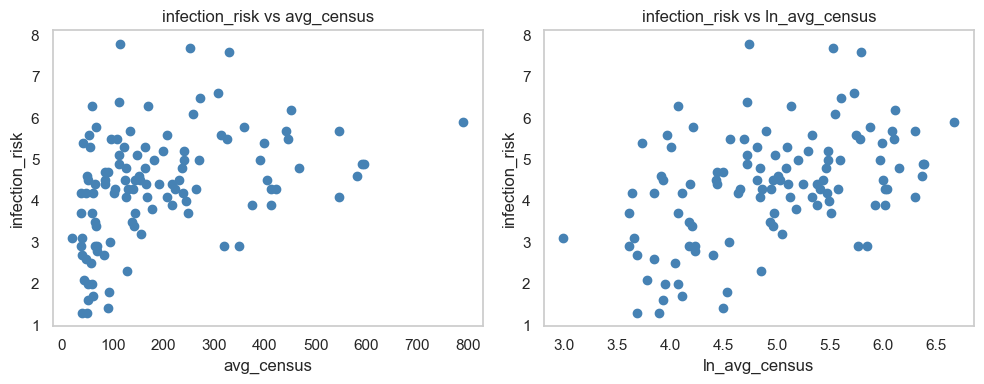

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
x1 = df['avg_census']
x2 = df['ln_avg_census']
y = df['infection_risk']
axs[0].scatter(x1, y, label='Scatter 1', color='steelblue', marker='o')
axs[0].set_title('infection_risk vs avg_census')
axs[0].set_xlabel('avg_census')
axs[0].set_ylabel('infection_risk')
axs[1].scatter(x2, y, label='Scatter 2', color='steelblue', marker='o')
axs[1].set_title('infection_risk vs ln_avg_census')
axs[1].set_xlabel('ln_avg_census')
axs[1].set_ylabel('infection_risk')
plt.tight_layout()
plt.show()

## Testing linear regression with least squares method

In [20]:
# Dropping categorical columns, while we decide how to deal with them
if 'med_school_affil' in df.columns or 'region' in df.columns:
    df.drop(columns=['med_school_affil', 'region'], inplace=True)

# # One-hot-encoding the categorical variables
# df = pd.get_dummies(df, columns=['med_school_affil', 'region'])
# df.head()

In [21]:
target_variable = 'infection_risk'
# All the variables in the dataset:
y_test, y_prediction = apply_linear_regression(df, target_variable)
print('r2 and rmse:', evaluate_linear_regression(y_test, y_prediction))

r2 and rmse: (0.6084117555745283, 0.8828957392625343)


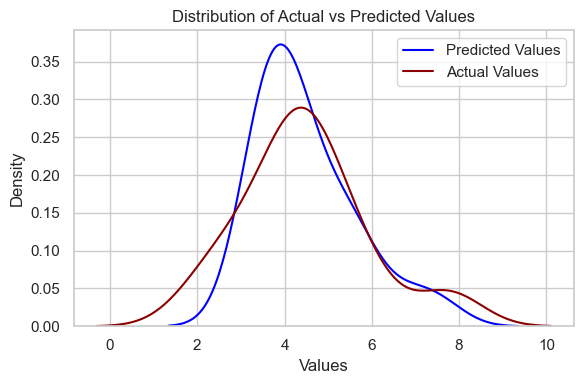

In [22]:
plot_distribution_actual_predicted(y_test, y_prediction)

### Removing outliers and running the Linear Regression again
* Removing hospitals with lenght of stay 18 (ID 112) and 20 (ID 47)
* Removing hospitals with routine_culturing_ratio of 60 (ID 8), 50 (ID 54) and 46 (ID 110)

In [44]:
indexes_to_drop = [40, 93, 107, 53, 13, 54]
df.loc[indexes_to_drop]

,lenght_of_stay,age,infection_risk,routine_culturing_ratio,routine_xray_ratio,num_beds,avg_census,num_nurses,avelbl_services,ln_num_beds,ln_avg_census,ln_num_nurses
40,8.2,60.9,1.3,1.9,58.0,73,49,21,14.3,4.3,3.9,3.0
93,8.9,53.9,1.3,2.2,79.5,56,40,14,5.7,4.0,3.7,2.6
107,7.1,51.7,1.4,4.1,45.7,115,90,19,22.9,4.7,4.5,2.9
53,11.4,61.1,7.6,16.6,97.9,535,330,273,51.4,6.3,5.8,5.6
13,12.8,56.8,7.7,46.0,116.9,322,252,349,57.1,5.8,5.5,5.9
54,12.1,43.7,7.8,52.4,105.3,157,115,76,31.4,5.1,4.7,4.3


In [45]:
df_no_outliers = df.drop(index=indexes_to_drop)

In [46]:
target_variable = 'infection_risk'
# All the variables in the dataset:
y_test, y_prediction = apply_linear_regression(df_no_outliers, target_variable)
print('r2 and rmse:', evaluate_linear_regression(y_test, y_prediction))

r2 and rmse: (-0.45634189509131406, 1.055310520095762)


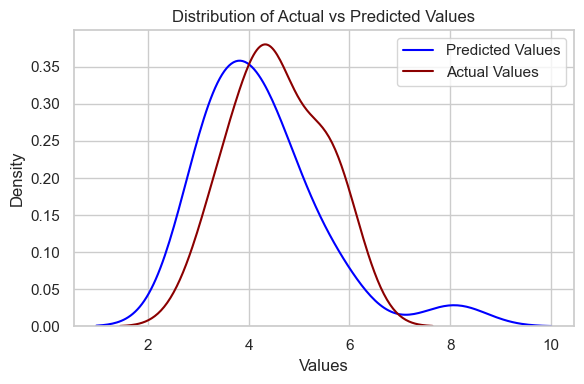

In [47]:
plot_distribution_actual_predicted(y_test, y_prediction)

In [42]:
# # Only the highly correlated:
# df_no_outliers_slice = df_no_outliers[['infection_risk', 'lenght_of_stay', 'routine_culturing_ratio']].copy()
# # print(df.head())
# y_test, y_prediction = apply_linear_regression(df_no_outliers_slice, target_variable)
# print('r2 and rmse:', evaluate_linear_regression(y_test, y_prediction))

In [43]:
# plot_distribution_actual_predicted(y_test, y_prediction)


## Doing the regression with MCMC
* First I'll do it with only one covariate (to test)

In [31]:
df_mcmc = df[['lenght_of_stay', 'infection_risk']]
df_mcmc.head()

,lenght_of_stay,infection_risk
1,7.1,4.1
2,8.8,1.6
3,8.3,2.7
4,8.9,5.6
5,11.2,5.7


In [32]:
x = np.array(df_mcmc)
x

array([[ 7.13,  4.1 ],
       [ 8.82,  1.6 ],
       [ 8.34,  2.7 ],
       [ 8.95,  5.6 ],
       [11.2 ,  5.7 ],
       [ 9.76,  5.1 ],
       [ 9.68,  4.6 ],
       [11.18,  5.4 ],
       [ 8.67,  4.3 ],
       [ 8.84,  6.3 ],
       [11.07,  4.9 ],
       [ 8.3 ,  4.3 ],
       [12.78,  7.7 ],
       [ 7.58,  3.7 ],
       [ 9.  ,  4.2 ],
       [11.08,  5.5 ],
       [ 8.28,  4.5 ],
       [11.62,  6.4 ],
       [ 9.06,  4.2 ],
       [ 9.35,  4.1 ],
       [ 7.53,  4.2 ],
       [10.24,  4.8 ],
       [ 9.78,  5.  ],
       [ 9.84,  4.8 ],
       [ 9.2 ,  4.  ],
       [ 8.28,  3.9 ],
       [ 9.31,  4.5 ],
       [ 8.19,  3.2 ],
       [11.65,  4.4 ],
       [ 9.89,  4.9 ],
       [11.03,  5.  ],
       [ 9.84,  5.2 ],
       [11.77,  5.3 ],
       [13.59,  6.1 ],
       [ 9.74,  6.3 ],
       [10.33,  5.  ],
       [ 9.97,  2.8 ],
       [ 7.84,  4.6 ],
       [10.47,  4.1 ],
       [ 8.16,  1.3 ],
       [ 8.48,  3.7 ],
       [10.72,  4.7 ],
       [11.2 ,  3.  ],
       [10.

In [33]:
# Defining the proposal distributions for a, b and \sigma
# a and b will be Normal, \sigma will be Gamma

def proposal(prec_theta, search_width = 0.5):
    # this function generates the proposal for the new theta
    # we assume that the distribution of the random variables 
    # is normal for the first two and gamma for the third.
    # conditional on the previous value of the accepted parameters (prec_theta)
    out_theta = np.zeros(3)
    out_theta[:2] = sc.multivariate_normal(mean=prec_theta[:2],cov=np.eye(2)*search_width**2).rvs(1)
    #the last component is the noise
    out_theta[2] = sc.gamma(a=prec_theta[2]*search_width*500, scale=1/(500*search_width)).rvs()
    return out_theta


In [34]:
def lhd(x,theta):
    # x is the data matrix, first column for input and second column for output.
    # theta is a vector containing the parameters for the evaluation
    # remember theta[0] is a, theta[1] is b and theta[2] is sigma
    xs = x[:,0]
    ys = x[:,1]
    lhd_out = sc.norm.logpdf(ys, loc=theta[0]*xs+theta[1], scale=theta[2])
    # then we sum lhd_out (be careful here, we are summing instead of multiplying
    # because we are dealing with the log-likelihood, instead of the raw likelihood).
    lhd_out = np.sum(lhd_out)
    return lhd_out

In [35]:
def prior(theta):
    # evaluate the prior for the parameters on a multivariate gaussian. 
    prior_out = sc.multivariate_normal.logpdf(theta[:2],mean=np.array([0,0]), cov=np.eye(2)*100)
    # this needs to be summed to the prior for the sigma, since I assumed independence.
    prior_out += sc.gamma.logpdf(theta[2], a=1, scale=1)
    return prior_out

In [36]:
def proposal_ratio(theta_old, theta_new, search_width=10):
    # this is the proposal distribution ratio
    # first, we calculate of the pdf of the proposal distribution at the old value of theta with respect to the new 
    # value of theta. And then we do the exact opposite.
    prop_ratio_out = sc.multivariate_normal.logpdf(theta_old[:2],mean=theta_new[:2], cov=np.eye(2)*search_width**2)
    prop_ratio_out += sc.gamma.logpdf(theta_old[2], a=theta_new[2]*search_width*500, scale=1/(500*search_width))
    prop_ratio_out -= sc.multivariate_normal.logpdf(theta_new[:2],mean=theta_old[:2], cov=np.eye(2)*search_width**2)
    prop_ratio_out -= sc.gamma.logpdf(theta_new[2], a=theta_old[2]*search_width*500, scale=1/(500*search_width))
    return prop_ratio_out

In [37]:
np.random.seed(100)
width = 0.2
thetas = np.random.rand(3).reshape(1,-1)
accepted = 0
rejected = 0
data = x
N = 100

for i in range(N):
    print(i)
    # 1) provide a proposal for theta
    theta_new = proposal(thetas[-1,:], search_width=width)
    
    # 2) calculate the likelihood of this proposal and the likelihood
    # for the old value of theta
    log_lik_theta_new = lhd(data,theta_new)
    log_lik_theta = lhd(data,thetas[-1,:])
    
    # 3) evaluate the prior log-pdf at the current and at the old value of theta
    theta_new_prior = prior(theta_new)
    theta_prior = prior(thetas[-1,:])
    
    # 4) finally, we need the proposal distribution ratio
    prop_ratio = proposal_ratio(thetas[-1], theta_new, search_width=width)
    
    # 5) assemble likelihood, priors and proposal distributions
    likelihood_prior_proposal_ratio = log_lik_theta_new - log_lik_theta + \
                             theta_new_prior - theta_prior + prop_ratio
    
    # 6) throw a - possibly infinitely weigthed - coin. The move for Metropolis-Hastings is
    # not deterministic. Here, we exponentiate the likelihood_prior_proposal ratio in order
    # to obtain the probability in linear scale
    if np.exp(likelihood_prior_proposal_ratio) > sc.uniform().rvs():
        thetas = np.vstack((thetas,theta_new))
        accepted += 1
    else:
        rejected += 1
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [38]:
thetas.shape[0]

13

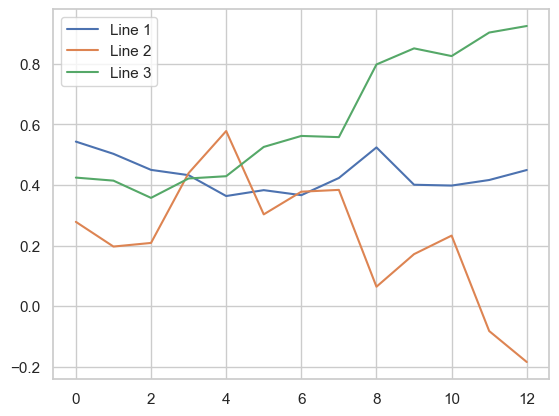

In [39]:
iteration = range(thetas.shape[0])
# Plotting each column as a line
plt.plot(iteration, thetas[:, 0], label='Line 1')  # First column as Line 1
plt.plot(iteration, thetas[:, 1], label='Line 2')  # Second column as Line 2
plt.plot(iteration, thetas[:, 2], label='Line 3')  # Third column as Line 3
plt.legend()

